# Introduction


## Data generation


PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Data structure

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Analysis preparation


## Load packages

In [1]:
import numpy as np 
import sklearn
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Load the data

In [2]:
transactions = pd.read_csv("C:/Users/neave/Documents/unscript/data/AIML Dataset.csv")

## Glimpse the data

In [3]:
print(f"Data shape: {transactions.shape}")

Data shape: (6362620, 11)


In [4]:
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data exploration

Let's start by checking for:

* columns names and types, and memory usage (info);
* aggregated functions for numerical values (describe);
* missing values;
* unique values.


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
transactions.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
missing_data(transactions)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
Total,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,object,float64,object,float64,float64,object,float64,float64,int64,int64


In [9]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [10]:
unique_values(transactions)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
Total,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
Uniques,743,5,5316900,6353307,1845844,2682586,2722362,3614697,3555499,2,2


## Visualization 

We continue with the distribution of the data (count plots for categorical values, values distribution for numerical values).

In [11]:
def plot_count(df, feature, title='', size=2.5):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.4f}%'.format(100*height/total),
                ha="center") 
    plt.show()


C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



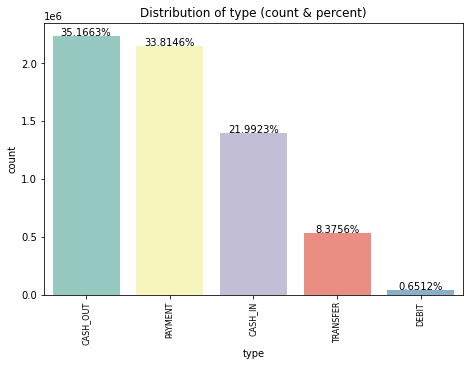

In [12]:
plot_count(transactions, 'type', 'Distribution of type (count & percent)', size=2.5)

C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



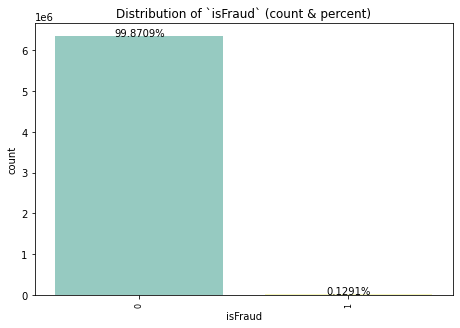

In [13]:
plot_count(transactions, 'isFraud', 'Distribution of `isFraud` (count & percent)', size=2.5)

C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



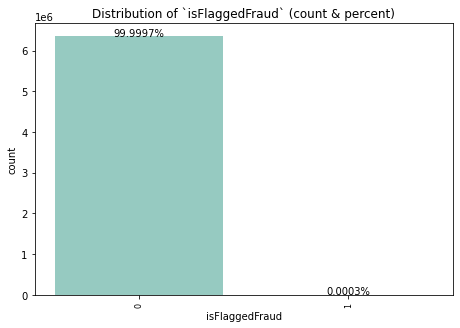

In [14]:
plot_count(transactions, 'isFlaggedFraud', 'Distribution of `isFlaggedFraud` (count & percent)', size=2.5)

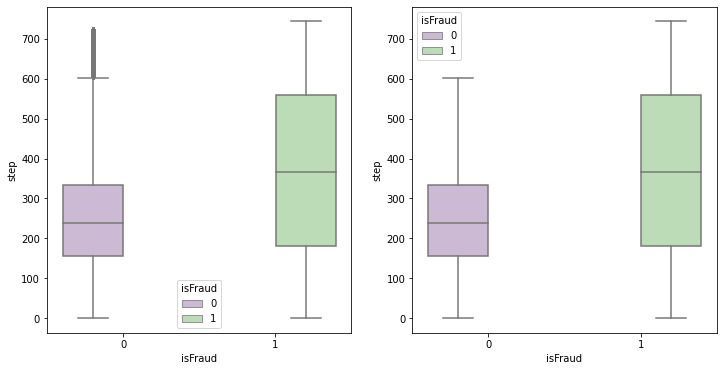

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="isFraud",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="isFraud",data=transactions, palette="PRGn",showfliers=False)
plt.show()

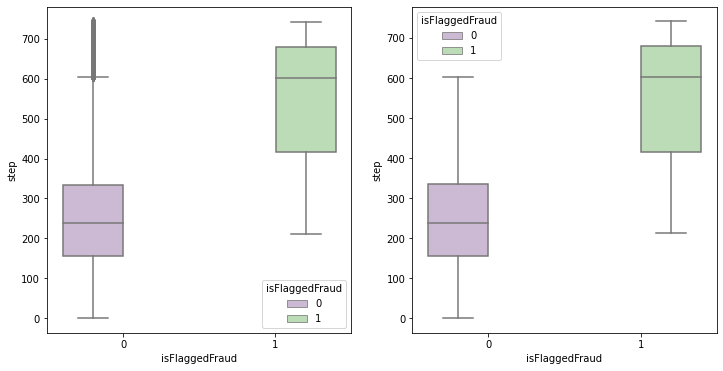

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFlaggedFraud", y="step", hue="isFlaggedFraud",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFlaggedFraud", y="step", hue="isFlaggedFraud",data=transactions, palette="PRGn",showfliers=False)
plt.show()

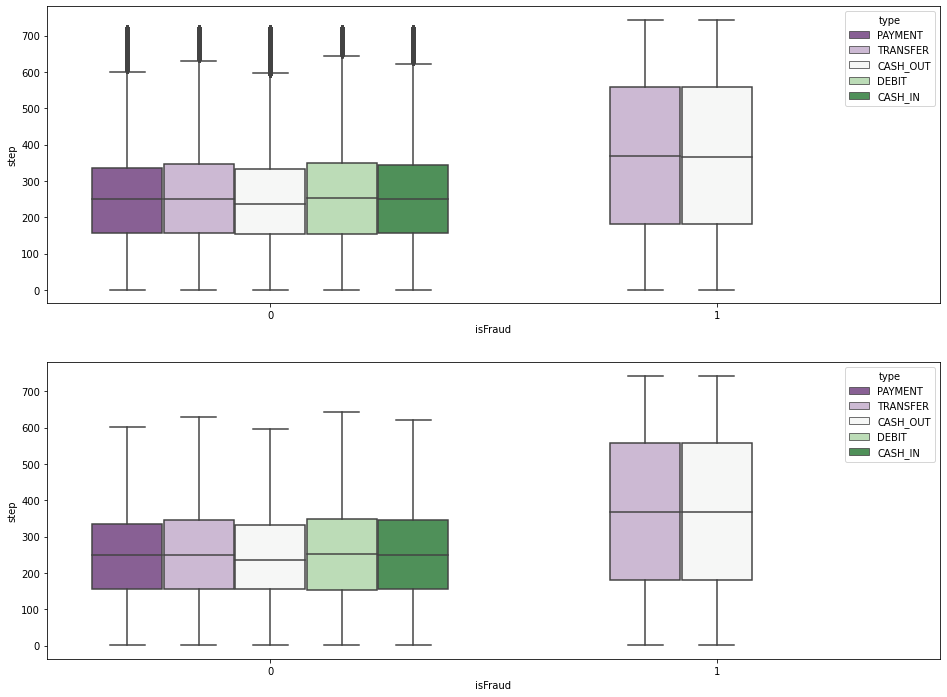

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

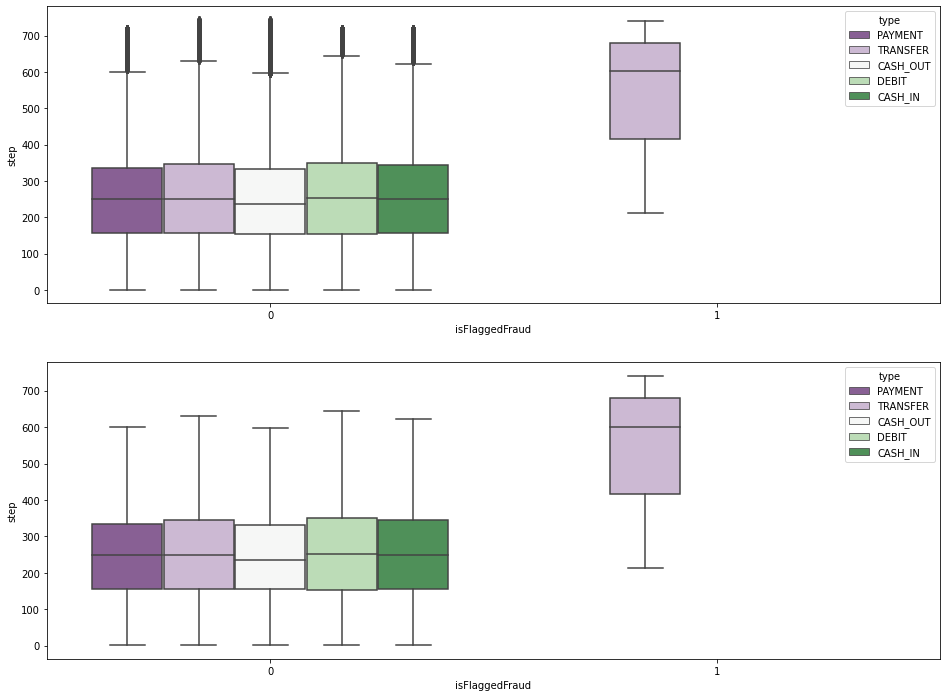

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFlaggedFraud", y="step", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFlaggedFraud", y="step", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

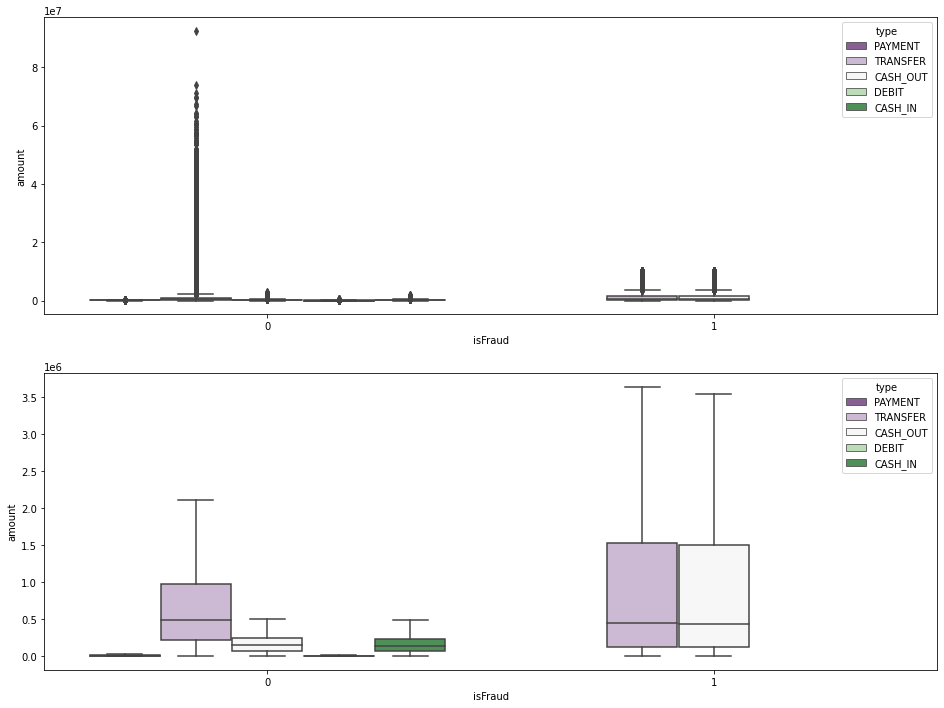

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

In [40]:
# Finding out the minimum and maximum transaction from Transfer and cash out transaction mode when it is set to be Fraud

print("Transfer Transaction")
print("Minimum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'TRANSFER')].amount.min())
print("Maximum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'TRANSFER')].amount.max())

print("\nCASH_OUT Transaction")
print("Minimum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'CASH_OUT')].amount.min())
print("Maximum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'CASH_OUT')].amount.max())

Transfer Transaction
Minimum Transaction : 63.8
Maximum Transaction : 10000000.0

CASH_OUT Transaction
Minimum Transaction : 0.0
Maximum Transaction : 10000000.0


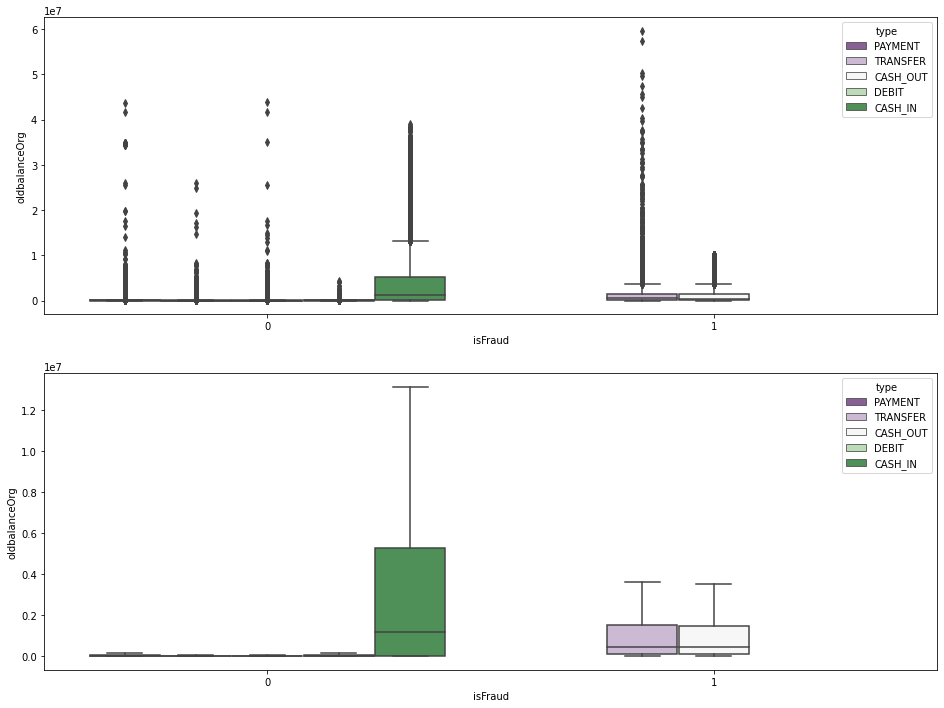

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceOrg", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceOrg", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

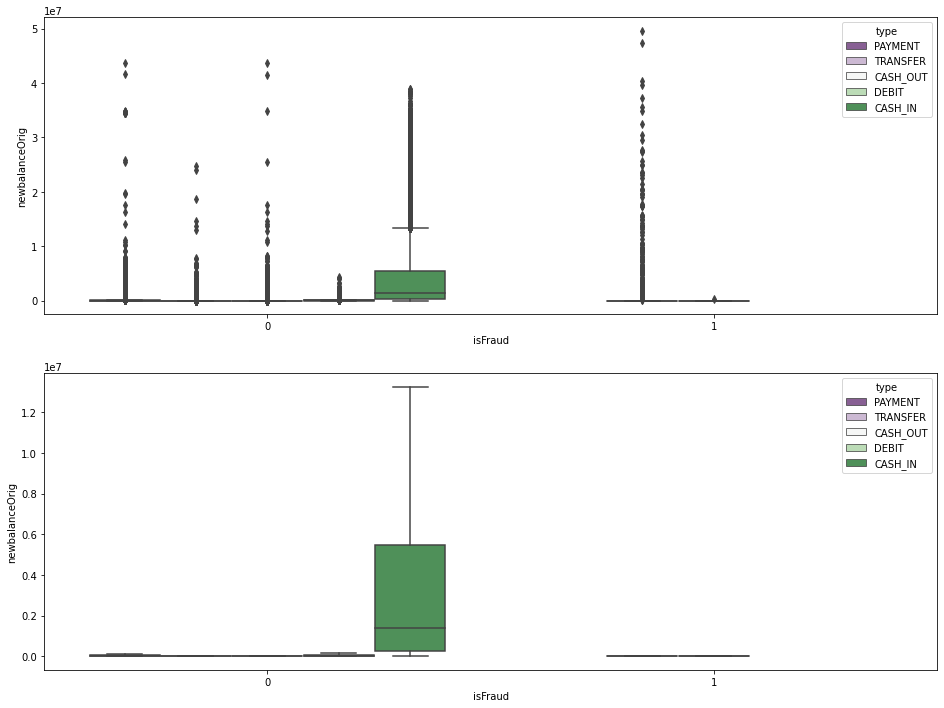

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceOrig", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceOrig", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

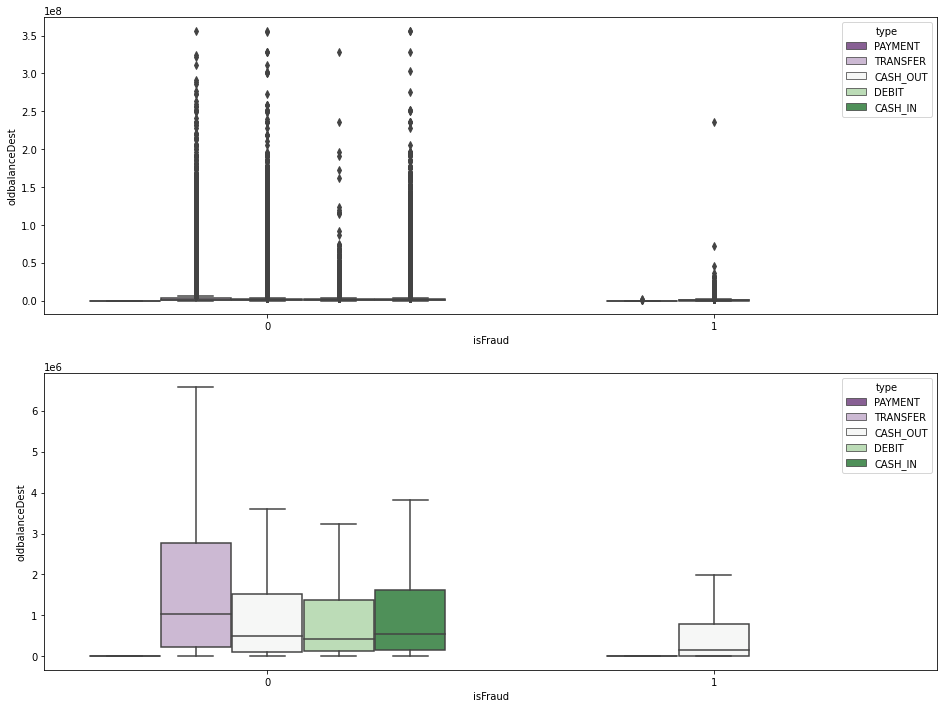

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceDest", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceDest", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

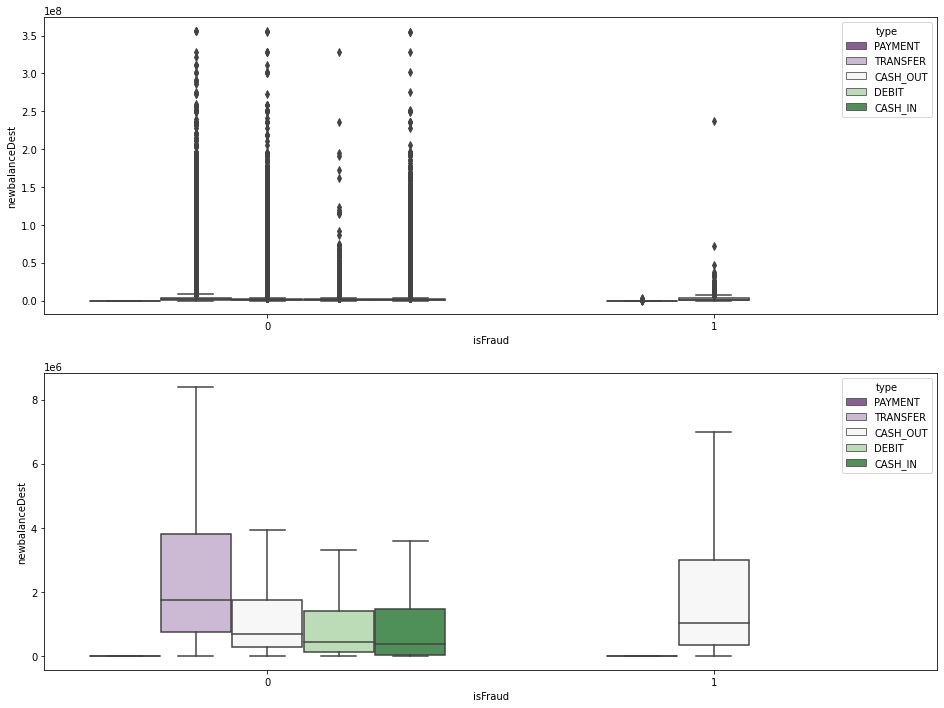

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceDest", hue="type",data=transactions, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceDest", hue="type",data=transactions, palette="PRGn",showfliers=False)
plt.show()

<AxesSubplot:>

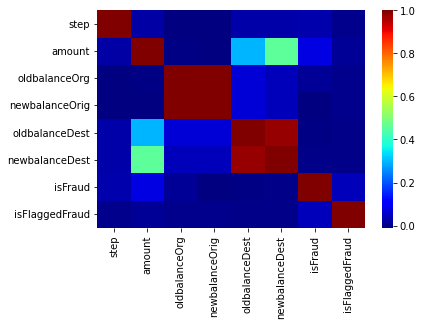

In [24]:
sns.heatmap(transactions.corr(), cmap='jet')

isFlaggedFraud can be cleaned out(dropped) as there seems to be no real significance of its being there

# Model

From the data, we will use 70% for training and 30% for validation.

CatBoostClassifier (CatBoost) algorithm is used.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

Prepare the features (X) and labels (y).

In [26]:
X = transactions.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = transactions.isFraud

Perform train-validation split.

In [27]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)

Specify the categorical features. CatBoost is very efficient in treatment of categorical features - no special processing (Label encoding, One-Hot encoding, Binary encoding) needed.

In [28]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

C:\Users\neave\AppData\Local\Temp/ipykernel_19332/1393882008.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [31]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.002, #0.002
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 25, #ideally less.... more for faster computing
                             od_wait=25)


In [32]:
clf.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7412193	best: 0.7412193 (0)	total: 8.11s	remaining: 1h 7m 26s
25:	test: 0.9945052	best: 0.9945052 (25)	total: 3m 12s	remaining: 58m 30s
50:	test: 0.9961176	best: 0.9961176 (50)	total: 9m 9s	remaining: 1h 20m 38s
75:	test: 0.9966451	best: 0.9966451 (75)	total: 15m 53s	remaining: 1h 28m 37s
100:	test: 0.9966576	best: 0.9966862 (79)	total: 24m 6s	remaining: 1h 35m 16s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9966862162
bestIteration = 79

Shrink model to first 80 iterations.


score

In [33]:
score = clf.score(X, y)
print(score)

0.9997139543144177


Prediction for validation set.

In [34]:
preds = clf.predict(X_validation)

Confusion matrix.

true +, false +, yada yada

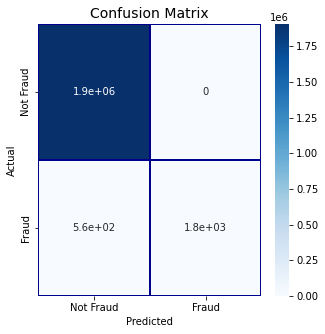

In [35]:
cm = pd.crosstab(y_validation.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Validation ROC-AUC:

ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

AUC is area under ROC curve.... The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes

In [36]:
print(f"ROC-AUC score: {roc_auc_score(y_validation.values, preds)}")

ROC-AUC score: 0.8837209302325582


In [37]:
print("scikit learn score:")
print(sklearn.metrics.accuracy_score(y_validation.values, preds)*100,"%")

scikit learn score:
99.97066198096591 %


In [38]:
print(sklearn.metrics.balanced_accuracy_score(y_validation.values, preds)*100, "%")

88.37209302325581 %


In [39]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(clf, open('fraudModelv1.pkl', 'wb'))